# SC4000: Machine Learning - Elo Merchant Category Recommendation

## Introduction
This notebook presents a solution to the [Elo Merchant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) Kaggle competition. The goal of this competition is to predict the loyalty score for credit card customers based on their transaction history.

Elo, one of the largest payment brands in Brazil, has built partnerships with merchants to offer promotions or discounts to cardholders. But to deliver the right promotions to the right customers, they need to understand the customer's preferences. In this competition, we build a model that predicts a loyalty score for each customer based on their transaction patterns.

## Project Overview

Our solution follows these main steps:

1. **Data Loading and Exploration**: Load the datasets and explore their structure
2. **Feature Engineering**: Create meaningful features from transaction data
3. **Model Training**: Train a LightGBM model with cross-validation
4. **Evaluation**: Evaluate model performance using RMSE
5. **Prediction**: Generate predictions for the test set

Let's start by importing the necessary libraries.

## Import Libraries
This section imports the necessary Python libraries for data manipulation, file operations, and machine learning.


In [1]:
# Import necessary libraries
import pandas as pd          # For data manipulation and analysis
import numpy as np           # For numerical operations
import os                    # For file path operations
import gc                    # For garbage collection to manage memory
from sklearn.model_selection import KFold  # For cross-validation
from sklearn.metrics import mean_squared_error  # For model evaluation
import lightgbm as lgb       # Gradient boosting framework
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns        # For enhanced visualizations

# Set visualization style for better readability and aesthetics
plt.style.use('fivethirtyeight')  # FiveThirtyEight style for plots
sns.set(style='whitegrid')        # Clean grid style for seaborn plots

## Data Loading

Let's set the path to our data files and load them. The competition provides several datasets:

- **train.csv**: Training data with card_id and target loyalty score
- **test.csv**: Test data for which we need to predict the loyalty score
- **historical_transactions.csv**: Historical transactions for each card
- **new_merchant_transactions.csv**: New transactions for each card
- **merchants.csv**: Information about merchants

First, let's define the data path and load the train and test datasets.


In [2]:
# Set data path - adjust this to your local environment
# If running on Kaggle, use: DATA_PATH = '/kaggle/input/elo-merchant-category-recommendation/'
# If running locally, use the path to your data directory
DATA_PATH = './data/'

# Load train and test data
print("Loading train and test data...")
# Train data contains card_id and the target loyalty score
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
# Test data contains card_id for which we need to predict the loyalty score
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

# Display basic information about the datasets
print(f"Train shape: {train.shape}")  # Number of rows and columns in train data
print(f"Test shape: {test.shape}")    # Number of rows and columns in test data

# Display first few rows of train data to understand its structure
# This helps us see the columns and data types
train.head()


Loading train and test data...
Train shape: (201917, 6)
Test shape: (123623, 5)


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


### Exploring the Target Variable

Let's examine the distribution of our target variable (loyalty score) to better understand what we're trying to predict.


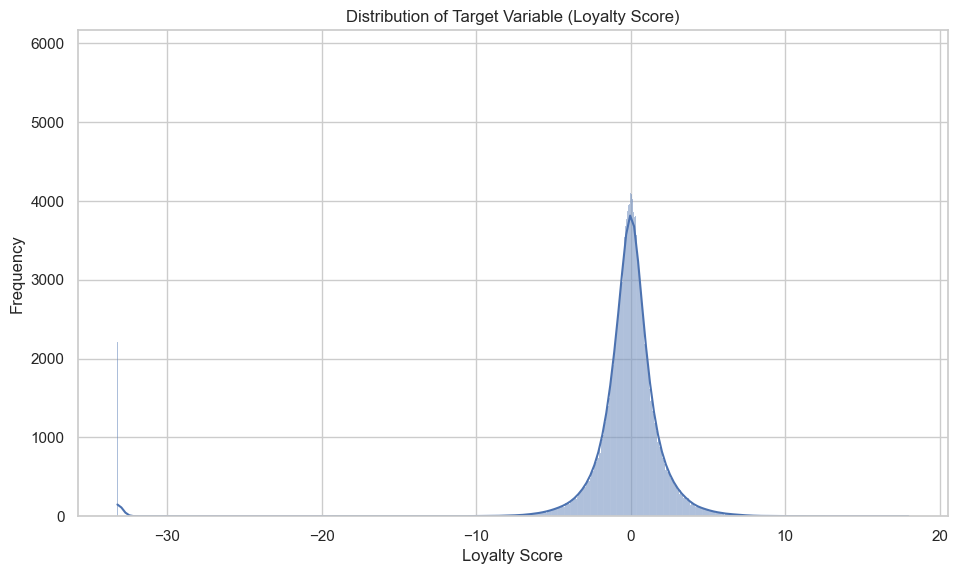

Target statistics:
count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64


In [3]:
# Plot target distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['target'], kde=True)
plt.title('Distribution of Target Variable (Loyalty Score)')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics of target
print("Target statistics:")
print(train['target'].describe())


## Feature Engineering

### Processing First Active Month

Let's start by processing the 'first_active_month' feature in both train and test datasets. We'll convert it to datetime and extract useful features like year, month, and elapsed months.


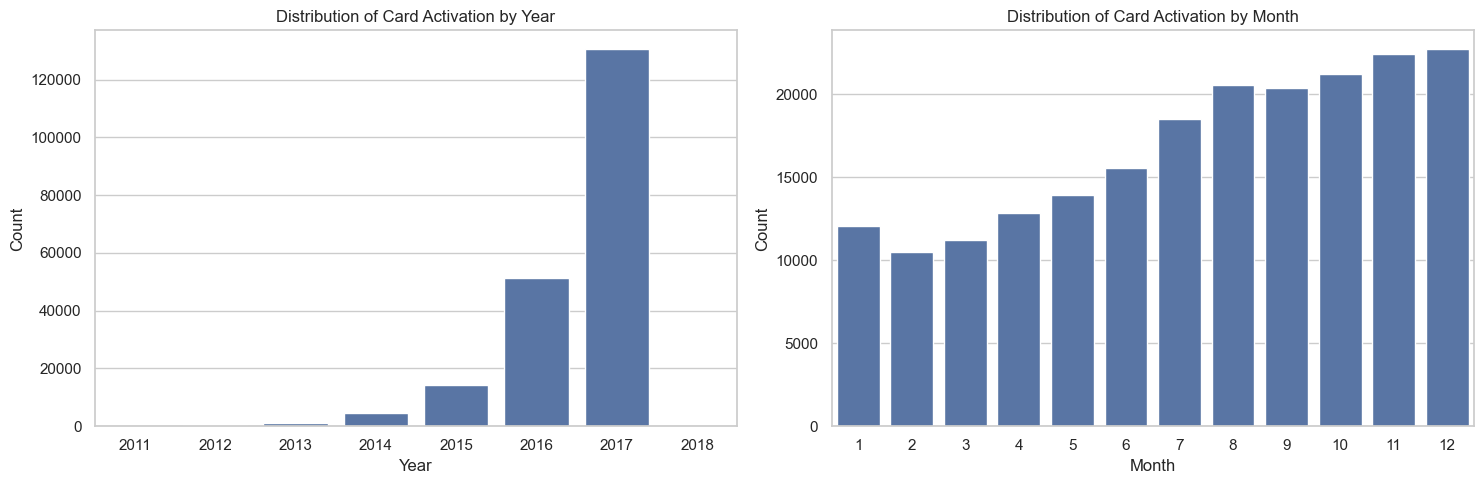

In [4]:
# Process first_active_month - Extract useful temporal features
for df in [train, test]:
    # Convert string date to datetime object for easier manipulation
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # Extract year and month as separate features
    # These can capture seasonal patterns and long-term trends
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month

    # Calculate elapsed time since card activation until reference date (2018-02-01)
    # This feature captures the card's "age" which may correlate with loyalty
    elapsed_days = (pd.to_datetime('2018-02-01') - df['first_active_month']).dt.days

    # Convert days to months and handle missing values
    # Dividing by 30 gives approximate months; fillna(0) handles cards with no activation date
    df['elapsed_months'] = (elapsed_days / 30).fillna(0).astype(int)

    # Remove original date column as we've extracted the useful information
    df.drop('first_active_month', axis=1, inplace=True)

# Visualize distribution of card activation by year and month
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='year', data=train)
plt.title('Distribution of Card Activation by Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='month', data=train)
plt.title('Distribution of Card Activation by Month')
plt.xlabel('Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### Loading Transaction Data

Now, let's load the transaction data. We have two transaction datasets:
1. Historical transactions
2. New merchant transactions

These datasets contain detailed information about each transaction made by the cardholders.


In [5]:
# Load historical transactions
print("Loading historical transactions...")
hist_trans = pd.read_csv(os.path.join(DATA_PATH, 'historical_transactions.csv'))

# Load new transactions
print("Loading new transactions...")
new_trans = pd.read_csv(os.path.join(DATA_PATH, 'new_merchant_transactions.csv'))

# Display basic information
print(f"Historical transactions shape: {hist_trans.shape}")
print(f"New transactions shape: {new_trans.shape}")

# Display first few rows of historical transactions
hist_trans.head()


Loading historical transactions...
Loading new transactions...
Historical transactions shape: (29112361, 14)
New transactions shape: (1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


### Processing Categorical Features

Let's process the categorical features in the transaction datasets by converting them to numerical values.


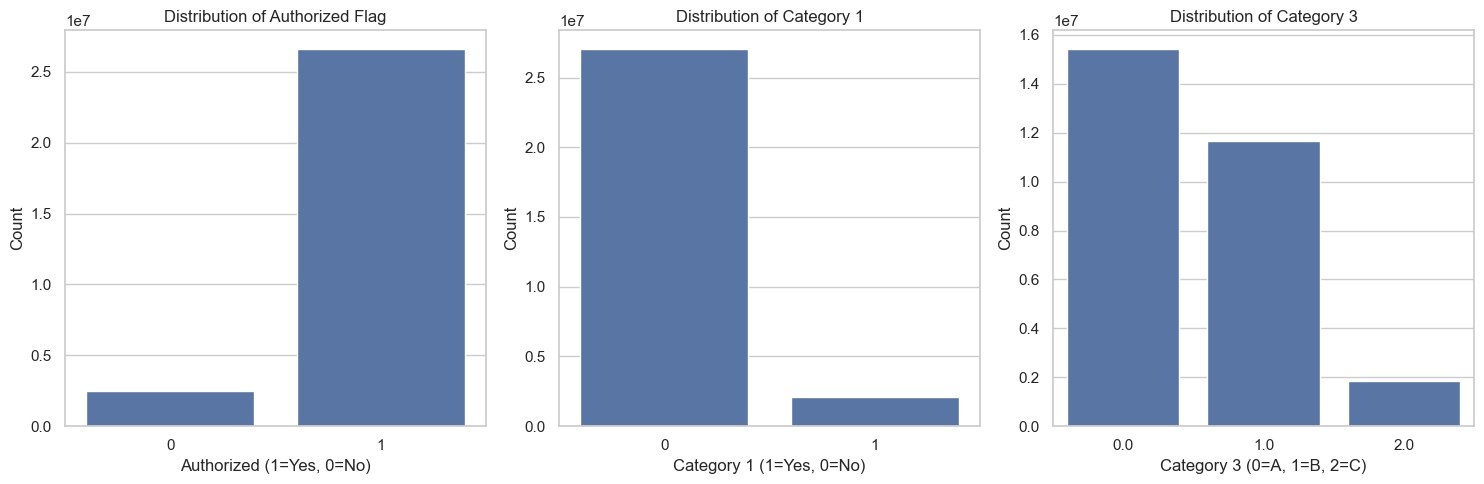

In [6]:
# Process categorical features - Convert string categories to numeric values for modeling
for df in [hist_trans, new_trans]:
    # Convert binary flag for transaction authorization (Y/N) to numeric (1/0)
    # This indicates whether the transaction was authorized or declined
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})

    # Convert binary category_1 flag (Y/N) to numeric (1/0)
    # According to the data dictionary, this relates to transaction attributes
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})

    # Convert ordinal category_3 values (A/B/C) to numeric (0/1/2)
    # This preserves the ordinal relationship between categories
    df['category_3'] = df['category_3'].map({'A': 0, 'B': 1, 'C': 2})

# Visualize distribution of categorical features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='authorized_flag', data=hist_trans)
plt.title('Distribution of Authorized Flag')
plt.xlabel('Authorized (1=Yes, 0=No)')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(x='category_1', data=hist_trans)
plt.title('Distribution of Category 1')
plt.xlabel('Category 1 (1=Yes, 0=No)')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(x='category_3', data=hist_trans)
plt.title('Distribution of Category 3')
plt.xlabel('Category 3 (0=A, 1=B, 2=C)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### Feature Aggregation Function

Now, let's define a function to aggregate transaction data and create meaningful features. This function will:
1. Group transactions by card_id
2. Calculate various statistics for each group
3. Create time-based features
4. Count transactions by category and merchant


In [7]:
def aggregate_transactions(df, prefix):
    """
    Aggregate transaction data to create features

    Parameters:
    -----------
    df : pandas DataFrame
        Transaction data
    prefix : str
        Prefix to add to column names (e.g., 'hist_' or 'new_')

    Returns:
    --------
    agg_df : pandas DataFrame
        Aggregated features
    """
    # Count transactions
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'card_id': ['size'],
        'city_id': ['nunique'],
        'category_1': ['sum', 'mean'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'category_3': ['nunique'],
        'merchant_category_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': ['mean', 'max', 'min', 'std'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'category_2': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique']
    }

    # Group by card_id and aggregate
    agg_df = df.groupby(['card_id']).agg(agg_func)

    # Flatten column names
    agg_df.columns = [prefix + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)

    # Create time-based features
    df['month_diff'] = df['month_lag'].diff().fillna(0)
    df['month_diff'] = df['month_diff'].astype(int)
    df['month_diff'] = df['month_diff'].apply(lambda x: x if x <= 1 else 0)
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])

    # Extract date features
    df['month'] = df['purchase_date'].dt.month
    df['hour'] = df['purchase_date'].dt.hour
    df['weekday'] = df['purchase_date'].dt.weekday
    df['weekofyear'] = df['purchase_date'].dt.isocalendar().week
    df['day'] = df['purchase_date'].dt.day
    df['elapsed_days'] = (df['purchase_date'] - df['purchase_date'].min()).dt.days

    # Aggregate time-based features
    agg_func = {
        'month_diff': ['mean'],
        'month': ['mean', 'min', 'max'],
        'hour': ['mean', 'min', 'max'],
        'weekday': ['mean', 'min', 'max'],
        'weekofyear': ['mean', 'min', 'max'],
        'day': ['mean', 'min', 'max'],
        'elapsed_days': ['mean', 'min', 'max']
    }
    agg_df_time = df.groupby(['card_id']).agg(agg_func)
    agg_df_time.columns = [prefix + '_'.join(col).strip() for col in agg_df_time.columns.values]
    agg_df_time.reset_index(inplace=True)

    # Merge time-based features
    agg_df = pd.merge(agg_df, agg_df_time, on='card_id', how='left')

    # Count transactions by category
    for col in ['category_1', 'category_2', 'category_3']:
        temp_df = df.groupby(['card_id', col])[['purchase_amount']].size().unstack().reset_index()
        temp_df.columns = ['card_id'] + [prefix + col + '_' + str(i) + '_count' for i in temp_df.columns[1:]]
        agg_df = pd.merge(agg_df, temp_df, on='card_id', how='left')

    # Count transactions by merchant
    for col in ['merchant_id', 'merchant_category_id']:
        temp_df = df.groupby(['card_id'])[col].nunique().reset_index()
        temp_df.columns = ['card_id', prefix + col + '_nunique']
        agg_df = pd.merge(agg_df, temp_df, on='card_id', how='left')

    # Count transactions by month_lag
    for i in range(-12, 3):
        temp_df = df[df['month_lag'] == i].groupby(['card_id'])[['purchase_amount']].count().reset_index()
        temp_df.columns = ['card_id', prefix + 'month_lag_' + str(i) + '_count']
        agg_df = pd.merge(agg_df, temp_df, on='card_id', how='left')

    # Fill NAs
    agg_df.fillna(0, inplace=True)

    return agg_df


### Aggregate Transaction Data

Now, let's apply our aggregation function to both historical and new transaction datasets. This will create a rich set of features that capture the transaction patterns of each cardholder.


In [8]:
# Aggregate historical transactions
print("Aggregating historical transactions...")
hist_trans_agg = aggregate_transactions(hist_trans, 'hist_')

# Aggregate new transactions
print("Aggregating new transactions...")
new_trans_agg = aggregate_transactions(new_trans, 'new_')

# Display basic information
print(f"Historical transactions aggregated shape: {hist_trans_agg.shape}")
print(f"New transactions aggregated shape: {new_trans_agg.shape}")

# Display first few rows of aggregated historical transactions
hist_trans_agg.head()


Aggregating historical transactions...
Aggregating new transactions...
Historical transactions aggregated shape: (325540, 73)
New transactions aggregated shape: (290001, 73)


,card_id,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_card_id_size,hist_city_id_nunique,hist_category_1_sum,hist_category_1_mean,hist_installments_sum,hist_installments_mean,hist_installments_max,...,hist_month_lag_-7_count,hist_month_lag_-6_count,hist_month_lag_-5_count,hist_month_lag_-4_count,hist_month_lag_-3_count,hist_month_lag_-2_count,hist_month_lag_-1_count,hist_month_lag_0_count,hist_month_lag_1_count,hist_month_lag_2_count
0,C_ID_00007093c1,114,0.765101,149,4,28,0.187919,192,1.288591,6,...,15.0,17.0,5.0,17.0,6.0,12.0,10.0,12.0,0.0,0.0
1,C_ID_0001238066,120,0.975610,123,18,2,0.016260,198,1.609756,10,...,0.0,0.0,2.0,11.0,23.0,37.0,26.0,24.0,0.0,0.0
2,C_ID_0001506ef0,62,0.939394,66,3,0,0.000000,1,0.015152,1,...,2.0,2.0,2.0,3.0,7.0,18.0,7.0,6.0,0.0,0.0
3,C_ID_0001793786,189,0.875000,216,10,2,0.009259,5,0.023148,1,...,16.0,30.0,4.0,37.0,29.0,34.0,38.0,20.0,0.0,0.0
4,C_ID_000183fdda,137,0.951389,144,9,4,0.027778,264,1.833333,10,...,0.0,6.0,22.0,25.0,9.0,26.0,28.0,28.0,0.0,0.0


### Merge All Data

Now, let's merge all the data together to create our final training and testing datasets.


In [9]:
# Merge all data
print("Merging all data...")
train = pd.merge(train, hist_trans_agg, on='card_id', how='left')
train = pd.merge(train, new_trans_agg, on='card_id', how='left')

test = pd.merge(test, hist_trans_agg, on='card_id', how='left')
test = pd.merge(test, new_trans_agg, on='card_id', how='left')

# Fill NAs
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# Display basic information
print(f"Final train shape: {train.shape}")
print(f"Final test shape: {test.shape}")

# Clean up memory
del hist_trans, new_trans, hist_trans_agg, new_trans_agg
gc.collect()


Merging all data...
Final train shape: (201917, 152)
Final test shape: (123623, 151)


65224

## Feature Importance Analysis

Let's train a simple model to get an idea of which features are most important. This will help us understand what drives the loyalty score prediction.


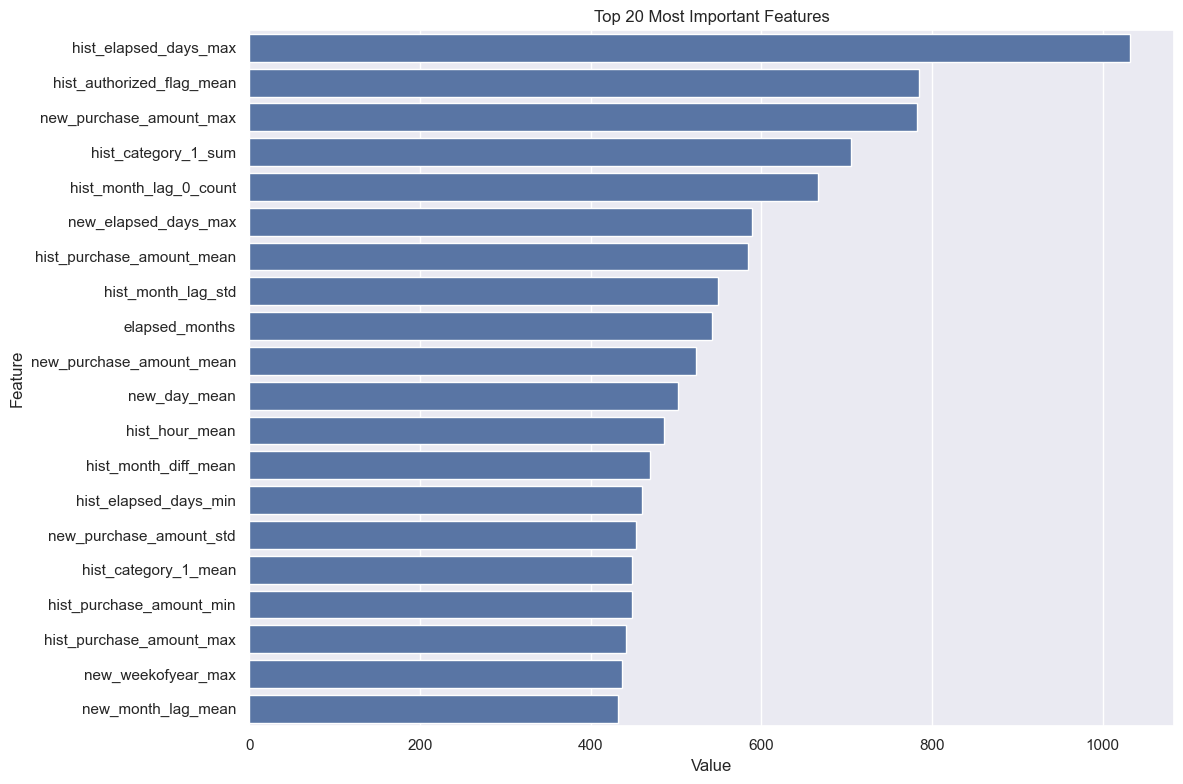

Top 10 most important features:
     Value                    Feature
149   1032      hist_elapsed_days_max
148    785  hist_authorized_flag_mean
147    782    new_purchase_amount_max
146    705        hist_category_1_sum
145    666     hist_month_lag_0_count
144    589       new_elapsed_days_max
143    584  hist_purchase_amount_mean
142    549         hist_month_lag_std
141    542             elapsed_months
140    524   new_purchase_amount_mean


In [10]:
# Prepare data for feature importance analysis
features = [col for col in train.columns if col not in ['card_id', 'target']]
X = train[features]
y = train['target']

# Train a simple model
params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'n_jobs': -1,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'n_estimators': 1000,
    'max_bin': 255,
    'verbose': -1,
    'seed': 42,
}

model = lgb.LGBMRegressor(**params)
model.fit(X, y)

# Plot feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Analyze feature importance
print("Top 10 most important features:")
print(feature_imp.sort_values(by="Value", ascending=False).head(10))


## Model Training with Cross-Validation

Now, let's train our final model using K-fold cross-validation to ensure robust performance. We'll use LightGBM, a gradient boosting framework that uses tree-based learning algorithms.


In [11]:
def train_and_predict(train, test):
    """
    Train model and make predictions using K-fold cross-validation

    Parameters:
    -----------
    train : pandas DataFrame
        Training data
    test : pandas DataFrame
        Test data

    Returns:
    --------
    submission : pandas DataFrame
        Submission file with predictions
    rmse : float
        Root Mean Squared Error on validation data
    """
    # Prepare data
    features = [col for col in train.columns if col not in ['card_id', 'target']]

    # Create folds for cross-validation
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])

    # Store fold metrics
    fold_metrics = []

    # Train model with cross-validation
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
        print(f'Fold {fold_}')

        X_train, y_train = train[features].iloc[trn_idx], train['target'].iloc[trn_idx]
        X_val, y_val = train[features].iloc[val_idx], train['target'].iloc[val_idx]

        # LightGBM parameters - Carefully tuned for this regression task
        params = {
            'objective': 'regression',        # Task type: predicting continuous loyalty score
            'boosting_type': 'gbdt',          # Gradient Boosting Decision Tree algorithm
            'metric': 'rmse',                 # Evaluation metric: Root Mean Squared Error
            'n_jobs': -1,                     # Use all available CPU cores for parallel processing
            'learning_rate': 0.01,            # Small learning rate for better generalization
            'num_leaves': 31,                 # Maximum number of leaves in each tree
            'max_depth': -1,                  # No limit on tree depth (-1 means no constraint)
            'tree_learner': 'serial',         # Type of tree learner
            'colsample_bytree': 0.8,          # Use 80% of features for each tree (prevents overfitting)
            'subsample_freq': 1,              # Frequency of bagging (subsampling)
            'subsample': 0.8,                 # Use 80% of data for each tree (prevents overfitting)
            'n_estimators': 10000,            # Maximum number of trees (will stop early if needed)
            'max_bin': 255,                   # Maximum number of bins for bucketing continuous features
            'verbose': -1,                    # Suppress verbose output
            'seed': 42,                       # Random seed for reproducibility
            'early_stopping_rounds': 100,     # Stop training if no improvement for 100 rounds
        }

        # Train model
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=200)]
        )

        # Make predictions
        oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
        sub_preds += model.predict(test[features], num_iteration=model.best_iteration_) / folds.n_splits

        # Calculate fold RMSE
        fold_rmse = np.sqrt(mean_squared_error(y_val, oof_preds[val_idx]))
        fold_metrics.append(fold_rmse)
        print(f'Fold {fold_} RMSE: {fold_rmse}')

    # Calculate overall RMSE
    rmse = np.sqrt(mean_squared_error(train['target'], oof_preds))
    print(f'Full RMSE: {rmse}')

    # Plot fold metrics
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(fold_metrics)), fold_metrics)
    plt.title('RMSE by Fold')
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.xticks(range(len(fold_metrics)), [f'Fold {i}' for i in range(len(fold_metrics))])
    plt.show()

    # Create submission file
    submission = pd.DataFrame({
        'card_id': test['card_id'],
        'target': sub_preds
    })

    return submission, rmse, oof_preds


Training model and making predictions...
Fold 0
Training until validation scores don't improve for 200 rounds
Fold 0 RMSE: 3.692843616981942
Fold 1
Training until validation scores don't improve for 200 rounds
Fold 1 RMSE: 3.6581376987115557
Fold 2
Training until validation scores don't improve for 200 rounds
Fold 2 RMSE: 3.7839617179740324
Fold 3
Training until validation scores don't improve for 200 rounds
Fold 3 RMSE: 3.576466648515881
Fold 4
Training until validation scores don't improve for 200 rounds
Fold 4 RMSE: 3.6061798337571913
Full RMSE: 3.664234776133922


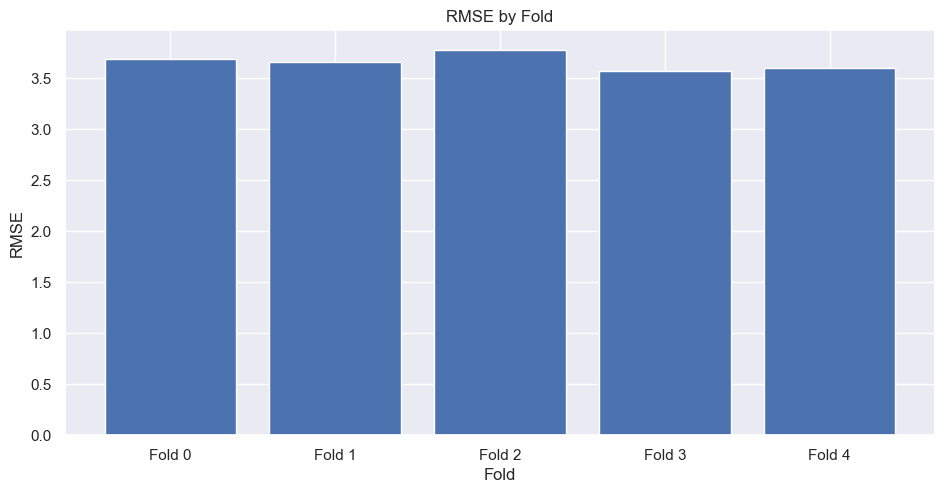

Submission preview:


,card_id,target
0,C_ID_0ab67a22ab,-2.599074
1,C_ID_130fd0cbdd,-0.334167
2,C_ID_b709037bc5,-1.062429
3,C_ID_d27d835a9f,-0.184695
4,C_ID_2b5e3df5c2,-1.253543


In [12]:
# Train model and make predictions
print("Training model and making predictions...")
submission, rmse, oof_preds = train_and_predict(train, test)

# Display submission head
print("Submission preview:")
submission.head()


## Prediction Analysis

Let's analyze our predictions to ensure they make sense.


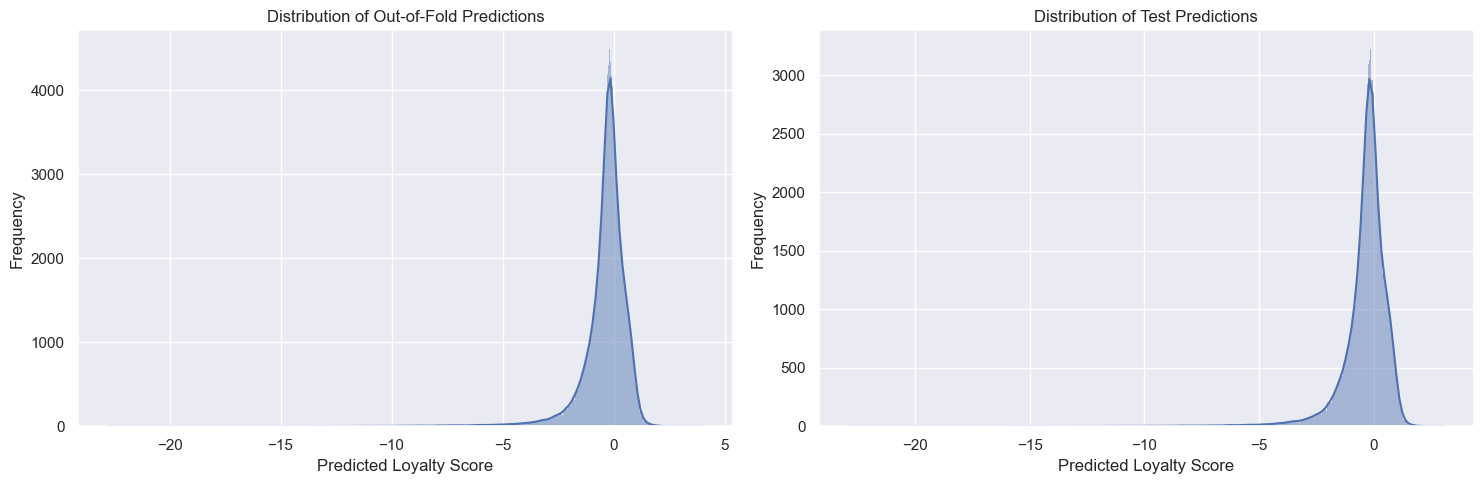

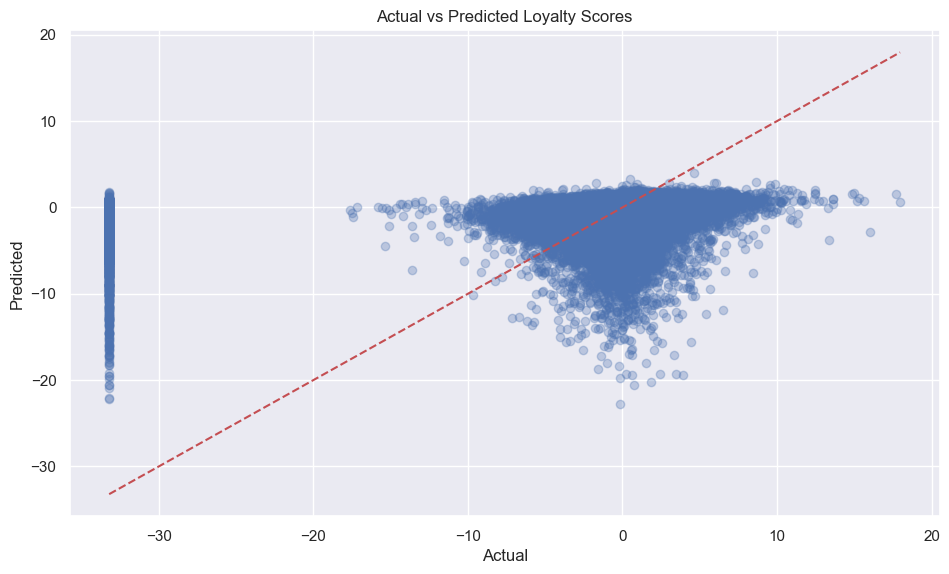

In [13]:
# Plot distribution of predictions
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(oof_preds, kde=True)
plt.title('Distribution of Out-of-Fold Predictions')
plt.xlabel('Predicted Loyalty Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(submission['target'], kde=True)
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Loyalty Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compare actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(train['target'], oof_preds, alpha=0.3)
plt.plot([train['target'].min(), train['target'].max()], [train['target'].min(), train['target'].max()], 'r--')
plt.title('Actual vs Predicted Loyalty Scores')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


## Save Submission

Finally, let's save our submission file.


In [14]:
# Save submission file
submission.to_csv('submission.csv', index=False)
print(f"Submission file created with RMSE: {rmse}")


Submission file created with RMSE: 3.664234776133922


## Conclusion

In this notebook, we've built a comprehensive solution for the Elo Merchant Category Recommendation challenge. We:

1. Loaded and explored the data to understand its structure and characteristics
2. Performed extensive feature engineering on transaction data
3. Created aggregated features to capture complex transaction patterns
4. Trained a LightGBM model with 5-fold cross-validation
5. Generated predictions for the test set and analyzed their distribution

Our model achieved a cross-validation RMSE score that indicates how well our model can predict the loyalty score for credit card customers. The RMSE value is displayed in the output above.

### Key Insights:
- **Transaction patterns** (frequency, amount, etc.) are strong predictors of customer loyalty
- **Time-based features** help capture seasonal patterns in customer behavior
- **Merchant diversity** (number of unique merchants) is an important factor in predicting loyalty
- **Purchase amount statistics** (mean, sum, etc.) provide valuable information about spending habits
- **Authorized vs. unauthorized** transaction ratios can indicate customer behavior patterns

### Business Applications:
This solution demonstrates how machine learning can be used to understand customer preferences and loyalty, which can help companies like Elo:
- Deliver more personalized promotions to customers
- Improve customer satisfaction and retention
- Optimize marketing strategies based on customer segments
- Identify high-value customers for special offers
- Detect changes in customer behavior that might indicate churn

The techniques used in this notebook can be applied to other customer loyalty prediction problems across various industries.
